In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
# loading dataloaders
batch_size = 64

train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [4]:
# printing out shapes
for X, y in test_dataloader:
    print(f'Shape of X[N, C, H, W]: {X.shape}')
    print(f'Shape of y: {y.shape} {y.dtype}')
    break

Shape of X[N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


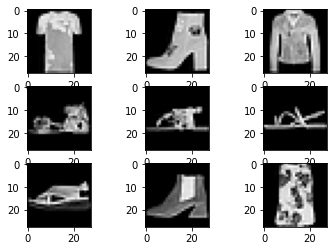

In [5]:
# printing data

import matplotlib.pyplot as plt
import random

for i in range(9):
    idx = random.randint(0, len(train_data))
    img_data = train_data[idx]
    img = img_data[0]
    img = torch.permute(img, [1, 2, 0])
    plt.subplot(330 + 1 + i)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.show()


In [6]:
# attempt at training models
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device {device}')

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        x = self.flatten(x) # flatten the image
        logits = self.linear_relu_stack(x)
        return logits

model = NN().to(device)
print(model)

Using device cpu
NN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [10]:
# optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [15]:
# training
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train() # tell the model you're training
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # get the values
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # reset the gradient and back prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [18]:
# testing
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad(): # disables calculation of gradient, faster
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item() # convert to normal float from torch tensor
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() # see how many you got correct
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [19]:
# run through data 5 times
epochs = 5
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.300133  [    0/60000]
loss: 2.290587  [ 6400/60000]
loss: 2.268536  [12800/60000]
loss: 2.267406  [19200/60000]
loss: 2.240919  [25600/60000]
loss: 2.217052  [32000/60000]
loss: 2.229613  [38400/60000]
loss: 2.189796  [44800/60000]
loss: 2.187907  [51200/60000]
loss: 2.151625  [57600/60000]
Test Error: 
 Accuracy: 36.2%, Avg loss: 2.150590 

Epoch 2
-------------------------------
loss: 2.158164  [    0/60000]
loss: 2.151278  [ 6400/60000]
loss: 2.093268  [12800/60000]
loss: 2.106265  [19200/60000]
loss: 2.051262  [25600/60000]
loss: 1.999510  [32000/60000]
loss: 2.021085  [38400/60000]
loss: 1.942392  [44800/60000]
loss: 1.946430  [51200/60000]
loss: 1.862755  [57600/60000]
Test Error: 
 Accuracy: 51.2%, Avg loss: 1.873087 

Epoch 3
-------------------------------
loss: 1.907203  [    0/60000]
loss: 1.877579  [ 6400/60000]
loss: 1.763753  [12800/60000]
loss: 1.794054  [19200/60000]
loss: 1.689504  [25600/60000]
loss: 1.651459  [32000/600

In [21]:
save_path = 'model.pth'
torch.save(model.state_dict(), save_path)
print(f'Saved torch model to {save_path}')

Saved torch model to model.pth


In [23]:
model = NN()
model.load_state_dict(torch.load(save_path)) # reload the model

<All keys matched successfully>

In [56]:
model.eval()

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

def evaluate(idx):
    x, y = test_data[idx][0], test_data[idx][1]
    with torch.no_grad():
        pred = model(x)
        predicted, actual = classes[pred[0].argmax(0)], classes[y]
        prob = pred.exp() / pred.exp().sum()
        sz = len(classes)
        for i in range(sz):
            print(f'{classes[i]:<12}: {prob[0][i].item():.4f}')
        print(f'Predicted: "{predicted}", Actual: "{actual}"')
    img = torch.permute(x, [1, 2, 0])
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.show()

T-shirt/top : 0.0021
Trouser     : 0.0012
Pullover    : 0.0077
Dress       : 0.0024
Coat        : 0.0068
Sandal      : 0.2129
Shirt       : 0.0058
Sneaker     : 0.2758
Bag         : 0.1011
Ankle boot  : 0.3844
Predicted: "Ankle boot", Actual: "Ankle boot"


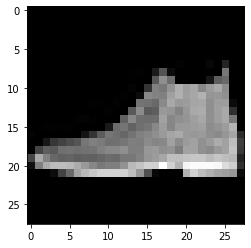

In [57]:
evaluate(0)

T-shirt/top : 0.1536
Trouser     : 0.0135
Pullover    : 0.2317
Dress       : 0.0445
Coat        : 0.1977
Sandal      : 0.0185
Shirt       : 0.2238
Sneaker     : 0.0055
Bag         : 0.0879
Ankle boot  : 0.0232
Predicted: "Pullover", Actual: "Shirt"


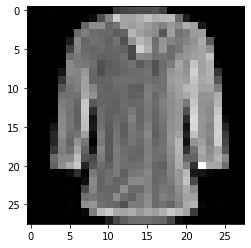

In [58]:
evaluate(4)